In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import sys

#import sep
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from astropy.io import fits

from improc.tools import *

#from dfreduce.detection import sextractor, sextractor_object_mask
#from dfreduce.viz import show_image
#from dfreduce import improc, astrometry, utils


In [2]:
# directions to your data

path_dir = '/Users/abraham/Dropbox/Data/Dragonfly301'
fn_8A = os.path.join(path_dir, os.path.join('2021-11-28','DRAGONFLY301_4_light_8A_WCS_ds_ff.fits'))
fn_30A = os.path.join(path_dir, os.path.join('2020-10-09','DRAGONFLY301_14_light_30A_WCS_ds_ff.fits'))

### Display the images

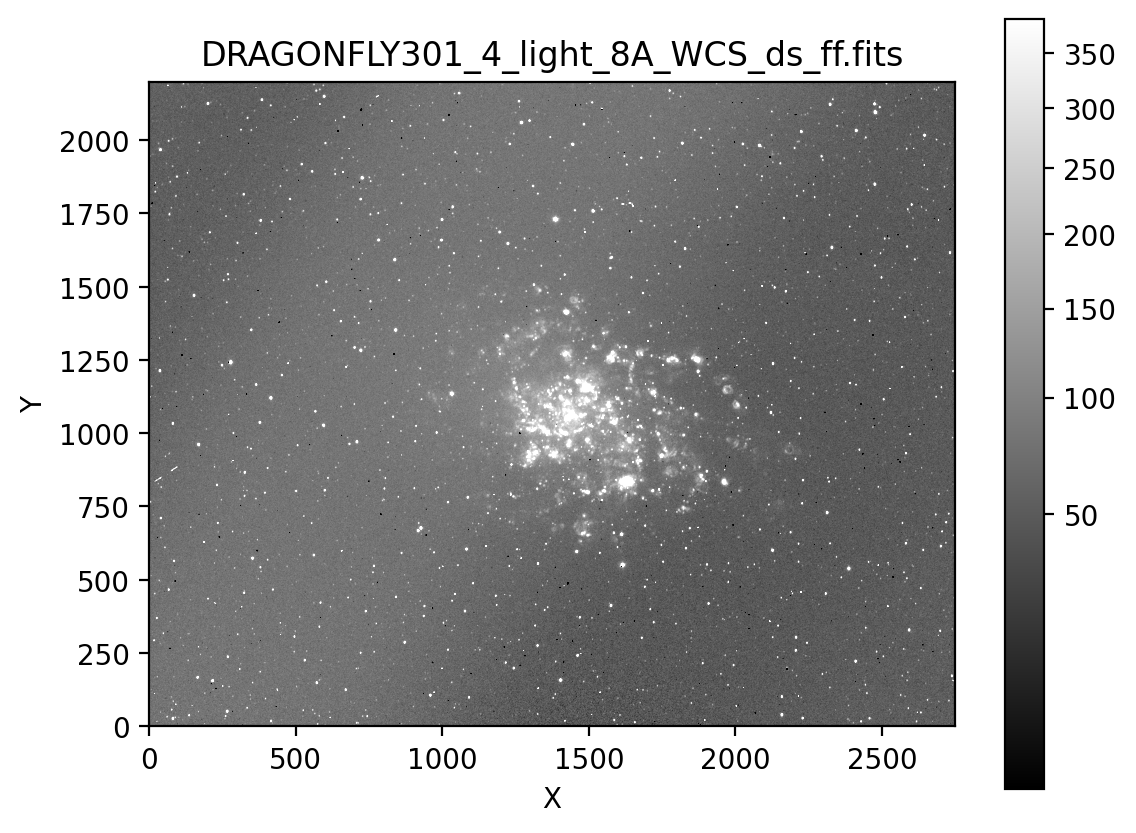

In [3]:
fig, ax = display(fn_8A)
#ds9(fn_8A)

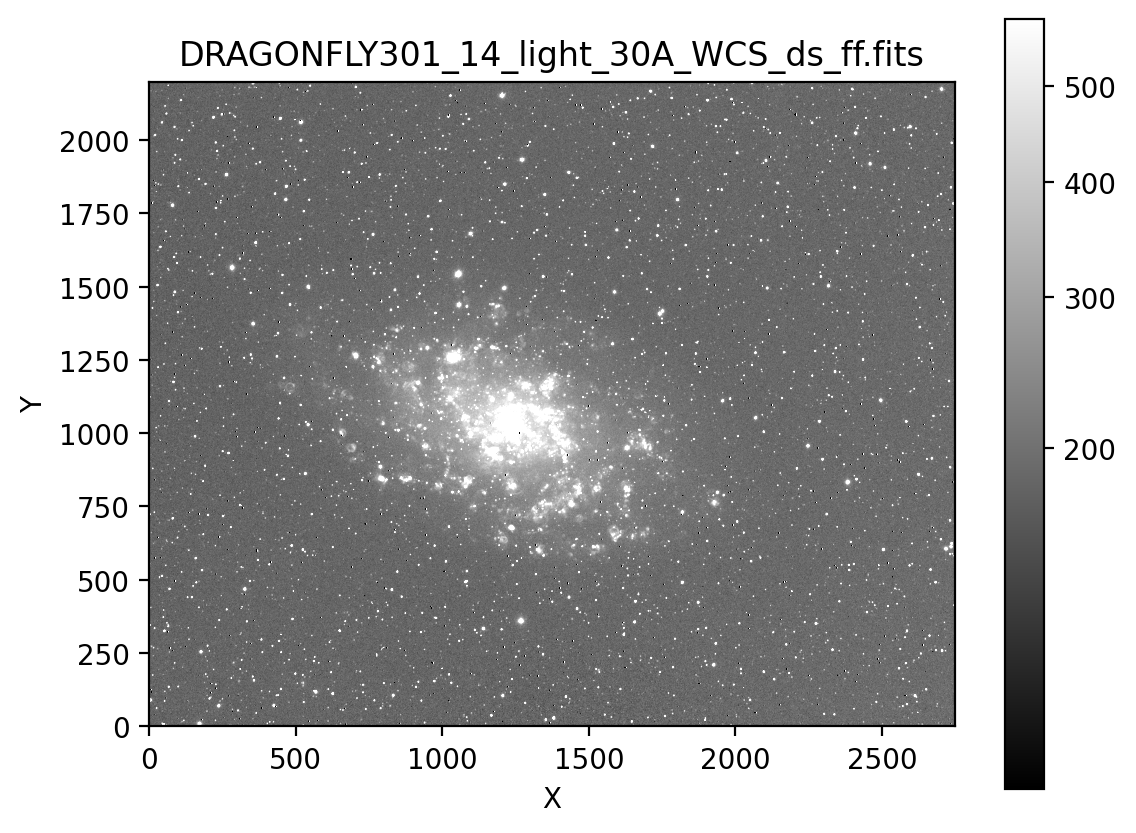

In [4]:
fig, ax = display(fn_30A)


### Basic stats (mean, median, standard deviation)

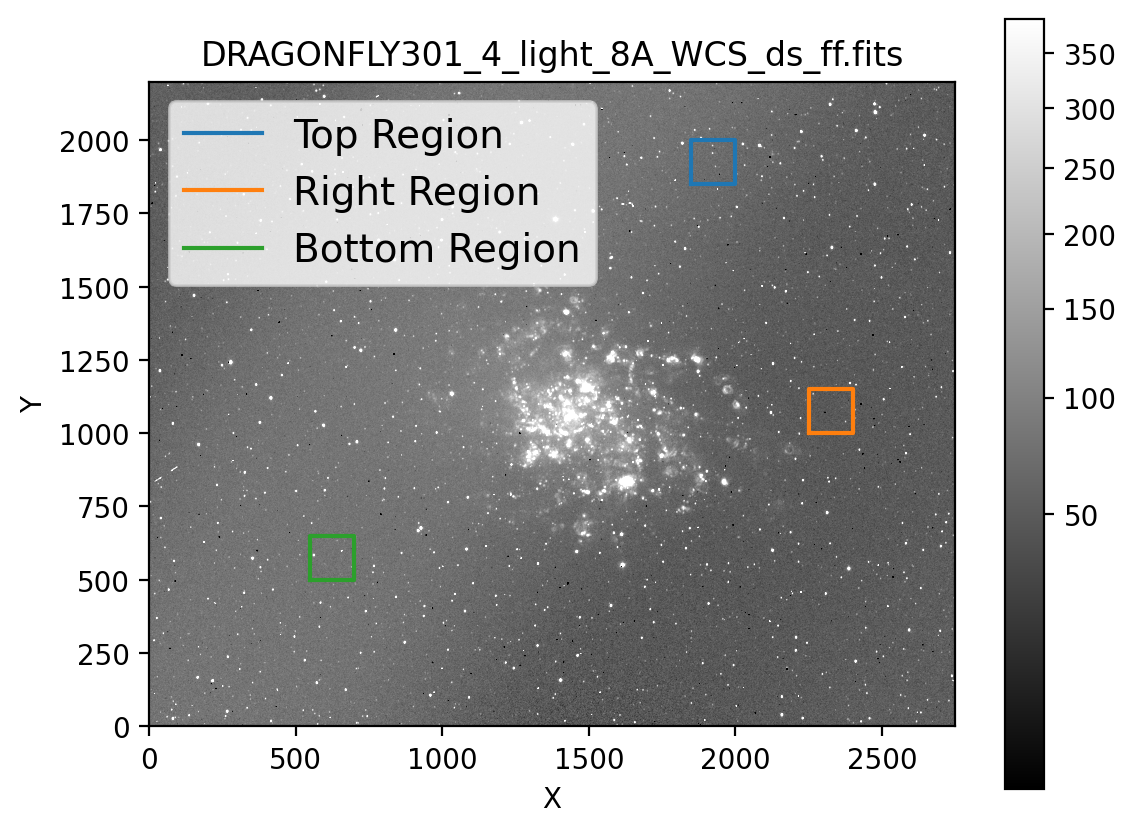

In [14]:
#data,header = utils.load_pixels_and_header(fn_8A)
# data, header = fits.getdata(fn_8A, header=True)
fig, ax = display(fn_8A, show=False)
ax.plot([1850,1850,2000,2000,1850],[1850,2000,2000,1850,1850],label='Top Region')
ax.plot([2250,2250,2400,2400,2250],[1000,1150,1150,1000,1000],label='Right Region')
ax.plot([550,550,700,700,550],[500,650,650,500,500],label='Bottom Region')
ax.legend(fontsize=14)

### Quick masking

In [13]:
def create_catalog(filename, detection_sigma = 2.0, min_area = 4, verbose=False, 
                   deblend=False):
    """create catalog - create a DataFrame of photometric and morphological properties 
                        for sources on an image.

    Args:
        filename (string): path to FITS image file to be analyzed.
        detection_sigma (float, optional): sky sigma for threshold. Defaults to 2.0.
        min_area (int, optional): minimum area of smallest objects. Defaults to 4.
        verbose (bool, optional): print diagnostic information. Defaults to False.

    Returns:
        DataFrame: catalog as a PANDAS DataFrame.
        SegmentationImage: segmentation map of the image as a numpy array.       
    """

    log.info("Reading in {}".format(filename))
    f = fits.open(filename,memmap=False)
    data, hdr = f[0].data, f[0].header
    f.close()
    
    log.info("Computing sky background level and standard deviation.") 
    sigma_clip = SigmaClip(sigma=3.0)

    bkg = ModeEstimatorBackground(median_factor=3.0, mean_factor=2.0, sigma_clip=sigma_clip)
    sky = bkg.calc_background(data)
    log.info("sky = {:.3f}".format(sky))
            
    bkgrms = StdBackgroundRMS(sigma_clip)
    skyrms = bkgrms.calc_background_rms(data)
    log.info("rms = {:.3f}".format(skyrms))
    
    log.info("Subtracting sky model")
    bkg_model = Background2D(data, (30, 30), filter_size=(11, 11), 
            sigma_clip=sigma_clip, bkg_estimator=bkg) 
    data_sub = data - bkg_model.background
    
    log.info("Detecting sources and making segmentation map")
    threshold = detection_sigma * skyrms
    segm = detect_sources(data_sub, threshold, npixels=min_area)

    if deblend:
        log.info("Deblending the segmentation map")
        segm_deblend = deblend_sources(data_sub, segm,
                                npixels=min_area, nlevels=32, contrast=0.001,
                                progress_bar=False)
    else:
        segm_deblend = segm

    log.info("Creating the source catalog")
    cat = SourceCatalog(data_sub, segm_deblend)
    df = cat.to_table().to_pandas()

    return df, segm_deblend

/Users/lokhorstd/miniforge3/envs/dfreduce/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


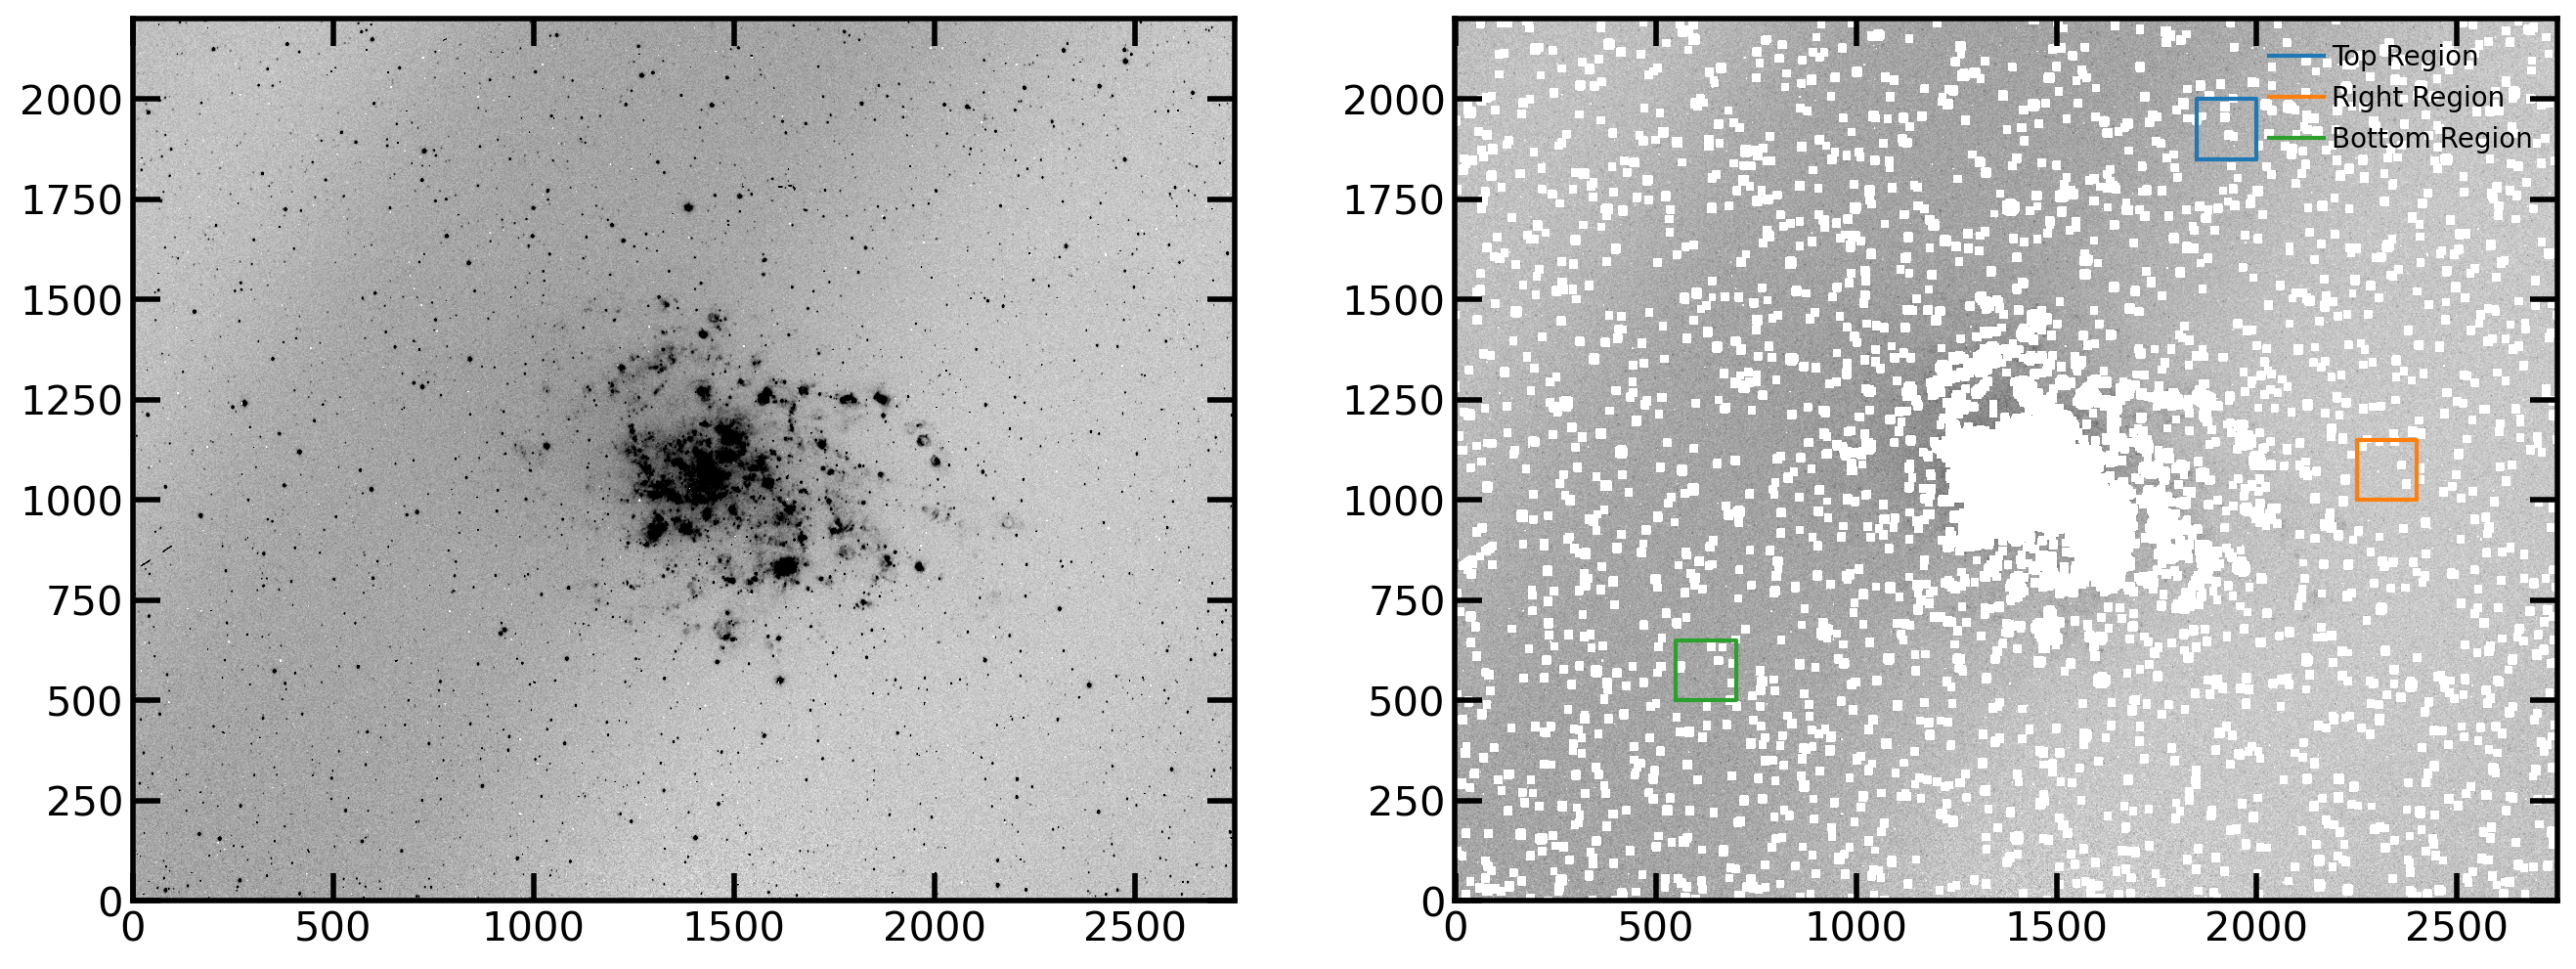

In [70]:
dilation = 15 # pixels
options = dict(PIXEL_SCALE=2.1, DETECT_THRESH=2.0, BACK_SIZE=256)
mask = sextractor_object_mask(data, dilate_npix=dilation, **options)

masked_data = np.ma.masked_array(data, mask=mask)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,16))
show_image(data,subplots=(fig,ax1))
show_image(masked_data,subplots=(fig,ax2))
ax2.plot([1850,1850,2000,2000,1850],[1850,2000,2000,1850,1850],label='Top Region')
ax2.plot([2250,2250,2400,2400,2250],[1000,1150,1150,1000,1000],label='Right Region')
ax2.plot([550,550,700,700,550],[500,650,650,500,500],label='Bottom Region')
ax2.legend()


The mean and median of the Top Region are 69.2 ADU and 69.2 ADU (stddev is 51.5) ADU.
The mean and median of the Top Region are 16.4 e- and 16.4 (stddev is 12.2) e-.

The mean and median of the Right Region are 47.3 ADU and 46.9 ADU (stddev is 29.6) ADU.
The mean and median of the Right Region are 11.2 e- and 11.1 e- (stddev is 7.0) e-.

The mean and median of the Bottom Region are 80.2 ADU and 79.5 ADU (stddev is 28.9 ADU).
The mean and median of the Bottom Region are 19.0 e- and 18.8 e- (stddev is 6.8 e-).


/Users/lokhorstd/miniforge3/envs/dfreduce/lib/python3.11/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Text(0.5, 1.0, 'Bottom Region')

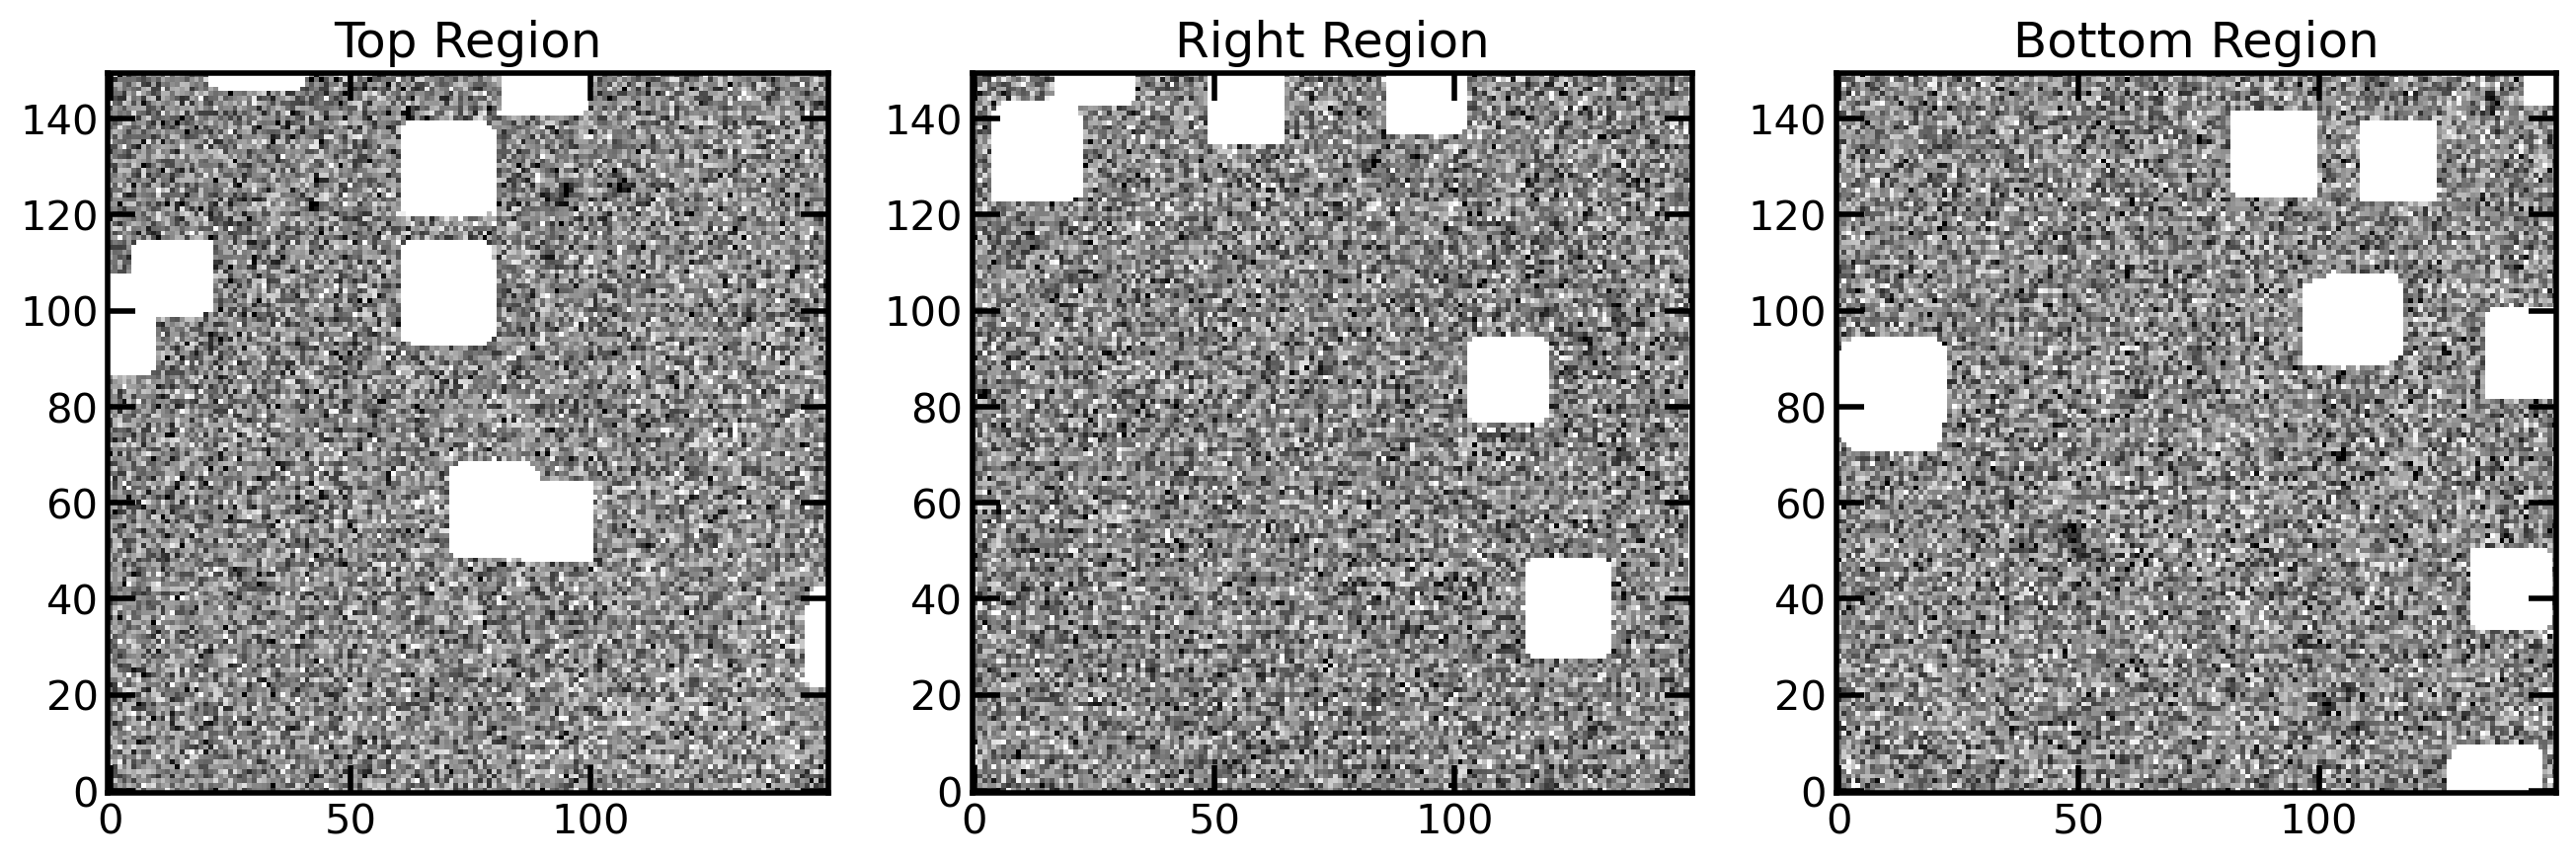

In [75]:
gain = 0.2363 # e-/ADU

mean_1,std_1,med_1= np.ma.mean(masked_data[1850:2000,1850:2000]),np.ma.std(masked_data[1850:2000,1850:2000]),np.ma.median(masked_data[1850:2000,1850:2000])
print(f'The mean and median of the Top Region are {mean_1:.1f} ADU and {med_1:.1f} ADU (stddev is {std_1:.1f}) ADU.')
print(f'The mean and median of the Top Region are {mean_1*gain:.1f} e- and {med_1*gain:.1f} (stddev is {std_1*gain:.1f}) e-.')
print()

mean_1,std_1,med_1= np.ma.mean(masked_data[1000:1150,2250:2400]),np.ma.std(masked_data[1000:1150,2250:2400]),np.ma.median(masked_data[1000:1150,2250:2400])
print(f'The mean and median of the Right Region are {mean_1:.1f} ADU and {med_1:.1f} ADU (stddev is {std_1:.1f}) ADU.')
print(f'The mean and median of the Right Region are {mean_1*gain:.1f} e- and {med_1*gain:.1f} e- (stddev is {std_1*gain:.1f}) e-.')
print()

mean_1,std_1,med_1= np.ma.mean(masked_data[500:650,550:700]),np.ma.std(masked_data[500:650,550:700]),np.ma.median(masked_data[500:650,550:700])
print(f'The mean and median of the Bottom Region are {mean_1:.1f} ADU and {med_1:.1f} ADU (stddev is {std_1:.1f} ADU).')
print(f'The mean and median of the Bottom Region are {mean_1*gain:.1f} e- and {med_1*gain:.1f} e- (stddev is {std_1*gain:.1f} e-).')

# ax2.plot([550,550,700,700,550],[500,650,650,500,500],label='Bottom Region')

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,16))
show_image(masked_data[1850:2000,1850:2000],subplots=(fig,ax1))
show_image(masked_data[1000:1150,2250:2400],subplots=(fig,ax2))
show_image(masked_data[500:650,550:700],subplots=(fig,ax3))
ax1.set_title('Top Region')
ax2.set_title('Right Region')
ax3.set_title('Bottom Region')